In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [8]:
ticker_list = ["SPY"]

In [9]:
def load_data(symbol):
    
    data = pd.read_csv(f"./data/{symbol}.csv")
    
    return data

In [10]:
def compute_returns(data):
    
    data = 100*(data-data[0])/data[0]
    
    return data

In [11]:
def compute_change(current_price, purchase_price_array):
    
    data = 100*(current_price-purchase_price_array)/purchase_price_array
    
    return data

In [12]:
data_list = []

for ticker in ticker_list:
    data = load_data(ticker)["Close"]
    if ticker != "VIX":
        data = compute_returns(data)
    data_list.append(data)
    

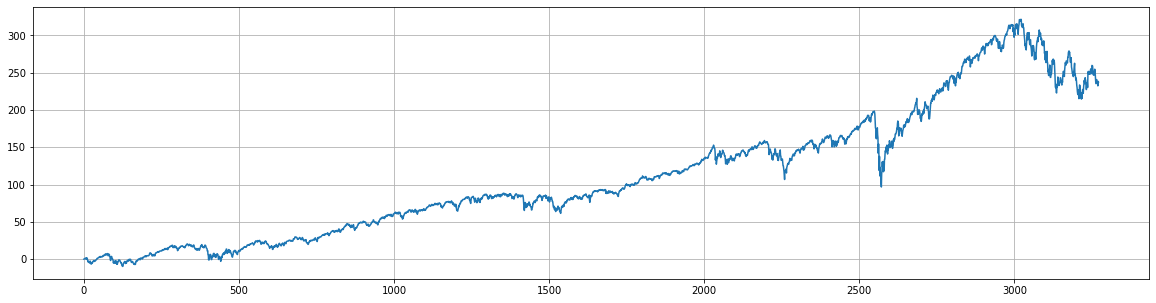

In [13]:
plt.figure(figsize=(20, 5))
plt.grid()

for price in data_list:
    plt.plot(price)
    
plt.show()

In [14]:
data_spy = load_data("SPY")
price = data_spy["Close"].values

In [26]:
# parameters

use_scheme = True

invest_at_bottom = 100
n_years_look_back = 1

In [16]:
def compute_howmuch_to_invest_vix(current_vix, vix_period, std_threshold=2):
    
    x = 0
    if current_vix > np.median(vix_period) + np.std(vix_period)*std_threshold:
        x = 100
    
    return x

In [29]:
def compute_howmuch_to_invest(current_price, period_low, investment_threshold_low, use_scheme):
    
    change_all_time_low = 100*(current_price-period_low)/period_low
    
    x = 100
    if use_scheme:
        x = 0
        if change_all_time_low <= investment_threshold_low:
            x = 100
    
    return x

In [34]:
def compute_returns(n_trading_days_look_back, look_back_years, investment_threshold, use_scheme=True):
    
    # invest every month, which means every 21 trading days per month on average
    n_trading_days_look_back = int(look_back_years*12*21)
    list_amount_and_price = []
    amount_to_invest = 1 # we start with 1 unit to invest (a sum that we can save every month to invest)

    for i in range(1, len(price)):

        until_present_prices = price[:i] # this is to make sure we avoid future leakage

        if (i % 21 == 0) and (i >= n_trading_days_look_back):
            
            current_price = until_present_prices[-1]
            period_low_price = np.min(until_present_prices[-n_trading_days_look_back:])
            all_time_high_price = np.max(until_present_prices)

#             percentage_to_invest = compute_howmuch_to_invest_vix(current_price, all_time_high_price, period_low_price, 
#                                                                  investment_threshold, use_scheme)
            percentage_to_invest = compute_howmuch_to_invest(current_price, period_low_price, investment_threshold, True)
            
            amount_invested = amount_to_invest*(percentage_to_invest/100)
            if np.abs(amount_invested - amount_to_invest) < 10e-4:
                amount_invested = amount_to_invest
            else:
                assert amount_invested <= amount_to_invest, f"problemo: amount invested {amount_invested}, amount to invest {amount_to_invest}"

            list_amount_and_price.append((amount_invested, current_price, amount_to_invest))
            amount_to_invest = 1 + amount_to_invest-amount_invested
            
    # print(list_amount_and_price)
    
    investment_list = np.array([val[0] for val in list_amount_and_price])
    price_list = np.array([val[1] for val in list_amount_and_price])

    changes_list = compute_change(price[-1], np.array(price_list))
    changes_list = 1 + changes_list/100

    # this is the number we are interested in optimising
    returns = 100*(np.sum(investment_list*changes_list)-len(investment_list))/len(investment_list)
    
    return returns

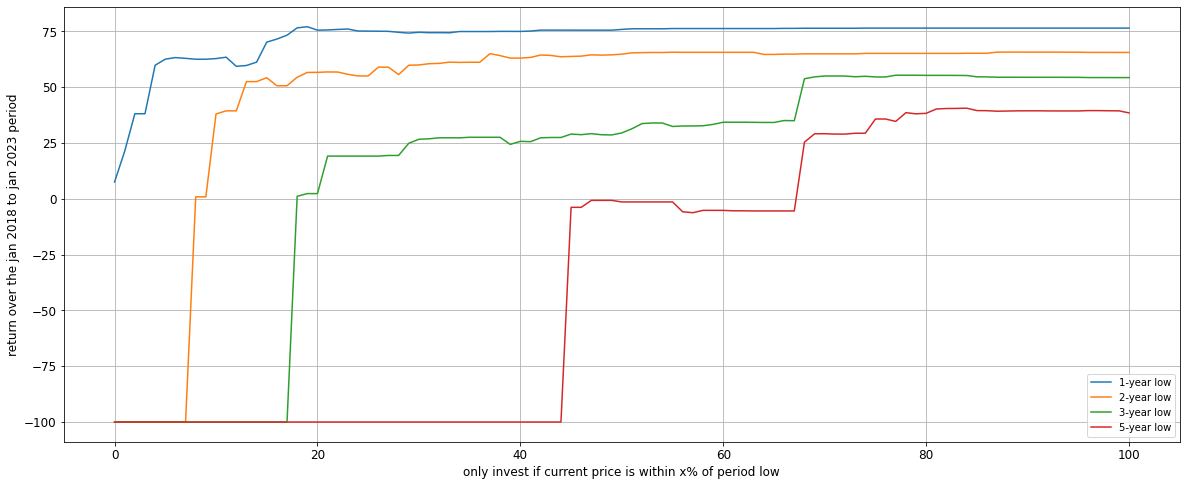

In [39]:
plt.figure(figsize=(20, 8))
plt.grid()
plt.xlabel("only invest if current price is within x% of period low", size=12)
plt.ylabel("return over the jan 2018 to jan 2023 period",  size=12)
plt.xticks(size=12)
plt.yticks(size=12)

for look_back_years in [1, 2, 3, 5]:
    
    returns_list = []
    
    for inv_low in np.arange(0, 101, 1):

        returns = compute_returns(n_trading_days_look_back, look_back_years, inv_low, use_scheme)
        returns_list.append(returns)
    
    plt.plot(returns_list)  

plt.legend(["1-year low", "2-year low", "3-year low", "5-year low"])
plt.savefig(f'graph_dca.png', dpi=600, bbox_inches='tight')    
plt.show()